<a href="https://colab.research.google.com/github/Folasewa/Deep_Learning_with_Tensorflow/blob/main/Time_Series_Common_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [ ]:
def plot_series(time, series, format ='-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize = 16)
    plt.grid(True)

Trend and Seasonality

In [ ]:
def trend(time, slope=0): #a linear trend function, there are other types of trends
    return slope * time

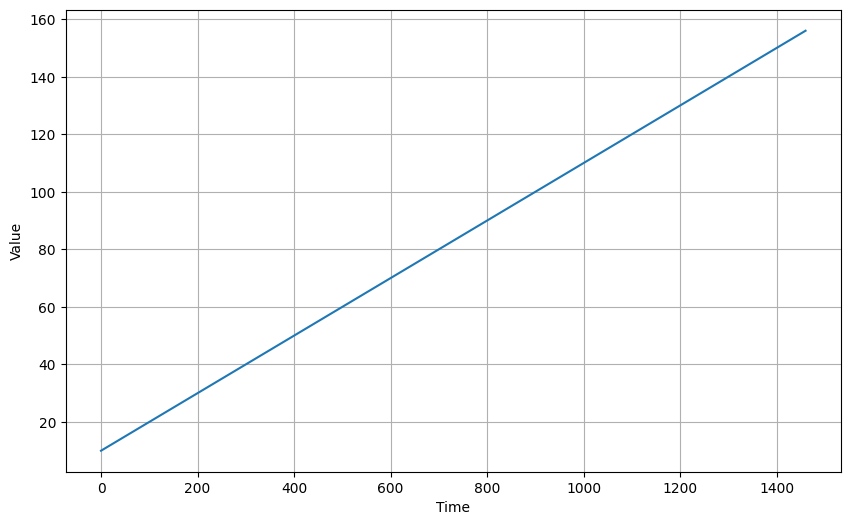

In [ ]:
#let's create a time series that trends upward

time = np.arange(4 * 365+1)
baseline = 10
series = baseline + trend(time, 0.1) #0.1 is the shope, the amount you add every step

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [ ]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [ ]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

Now let's create a time series with seasonal patterns

In [ ]:
def seasonal_pattern(season_time): # this generates a cosine graph in the first 40% and the remaining 60% is an inverse exponential shape
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0): # this seasonality function repeats the seaconal pattern many times
    "repeats the same pattern at each period"
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


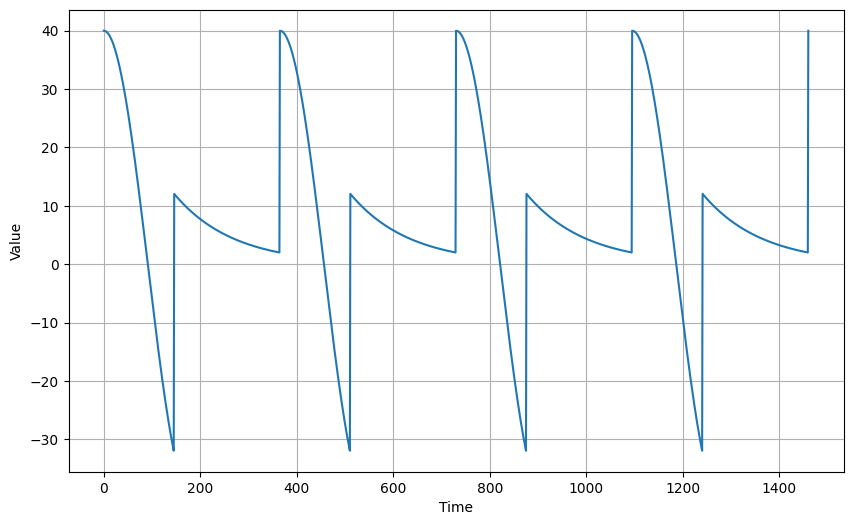

In [ ]:
amplitude = 40 # how high the pattern is
series = seasonality(time, period=365, amplitude = amplitude) #period is how oftem the pattern is repeated, here it is define 365 days; phase is how much the pattern is shifted relative to absolute time
plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

Let's create time series with both trend and seasonality

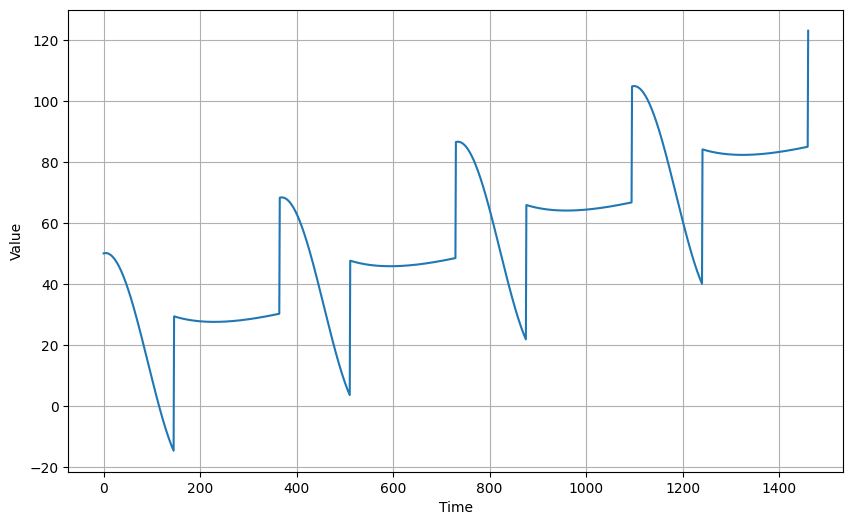

In [ ]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

Noise
real life time series has noise

In [ ]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

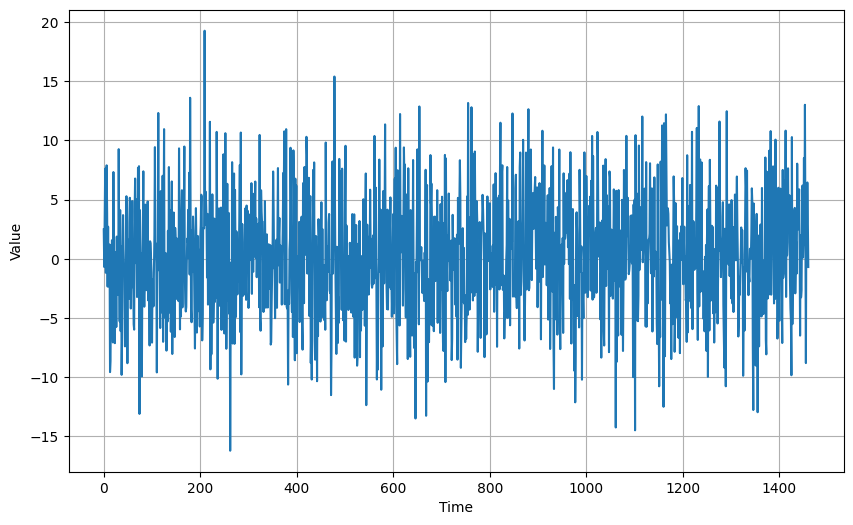

In [ ]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

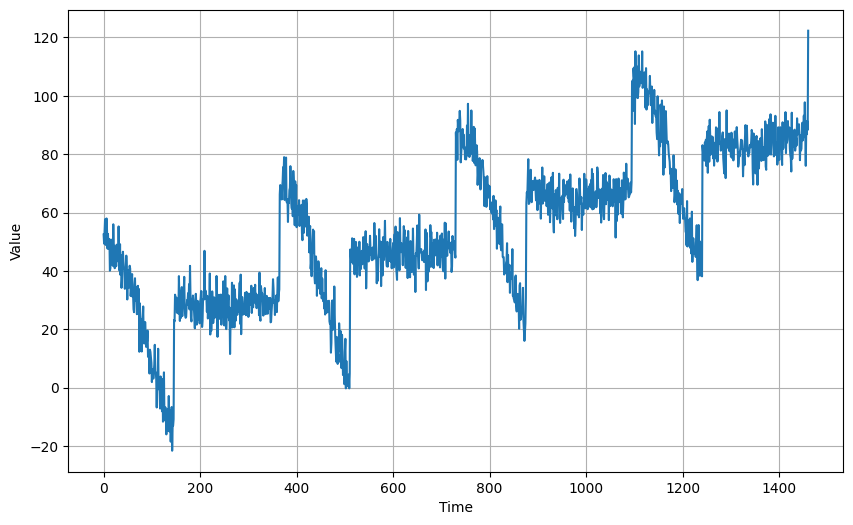

In [ ]:
#adding noise to the time series
series += noise
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show() #this is a plot of seasonality + trend + noise. in studying time series distribution, you could isolate each of these components

Naive Forecasting - Take the last value and assume that the next value will be the same
To measure the performance of your time series, split your time series into training, validation and test periods in a process known as fixed partitioning. You train your model on the training period and evaluate your model on the validation period. You then train on both train and valuation and evaluate on the test period to get an idea of how well your model will work in production.

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]



In [ ]:
naive_forecast = series[split_time - 1:-1] #day 999 split time - 1, copy till the previous till the last day value


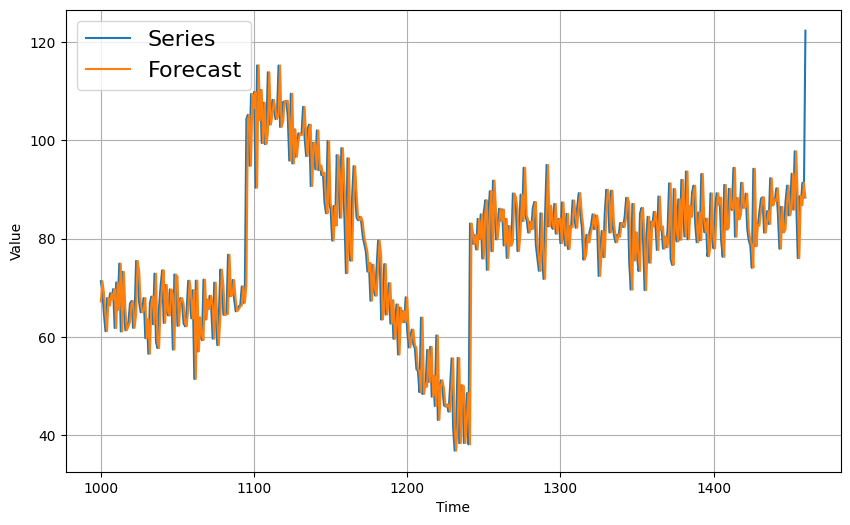

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, naive_forecast, label = 'Forecast')

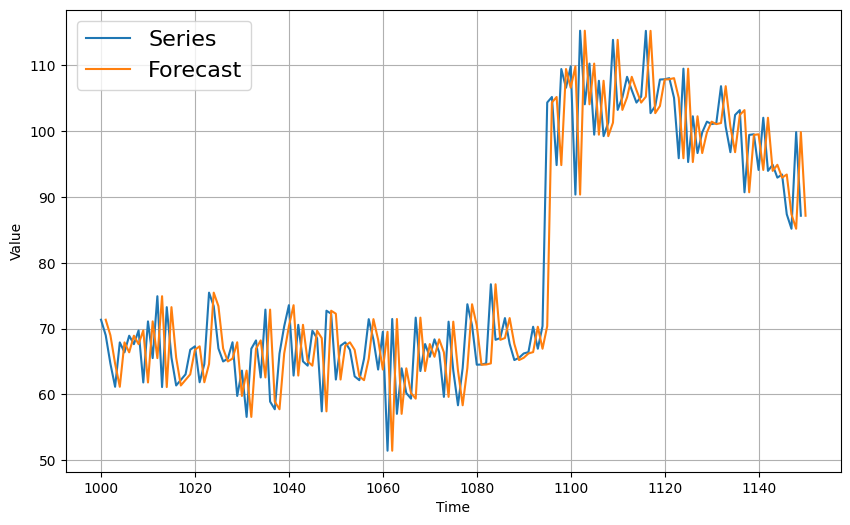

In [ ]:
#zooming in on the start of the validation period
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid, start=0, end=150, label='Series')
plot_series(time_valid, naive_forecast, start=1, end = 151, label = 'Forecast') #the exact data shifted by 1 day



Let's compute the mean squared error between the forecasts and the predictions in the validation period

In [ ]:
errors = naive_forecast - x_valid
abs_error = np.abs(errors)
mae = np.mean(abs_error)
mae

5.9379085153216735

Moving Average Forecast

with moving average forecast, you are saying tomorrow will be close to the average of the values over the past few days unlike naive forecast where you say tomorrow will be the same as today

In [ ]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [ ]:
def moving_average_forecast(series, window_size): #this function is a faster implementation
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size -1:-1]/window_size

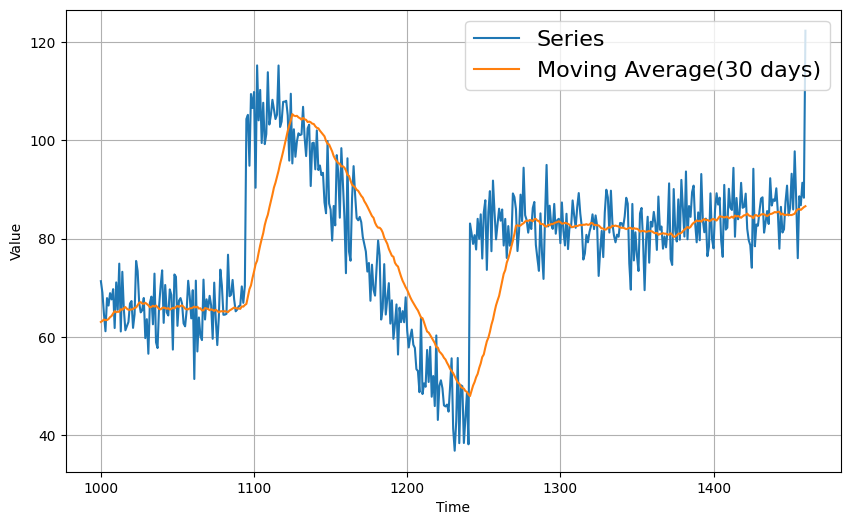

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label = 'Series')
plot_series(time_valid, moving_avg, label = 'Moving Average(30 days)')

In [ ]:
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(x_valid, moving_avg)
mae = mae_metric.result().numpy()
print(mae)

7.1424184


This result is worse than naive forecasting that gave an mae of 5.9. The moving average does not anticipate trend or seasonality so we try to remove them uisng differencing. Since the seasonality is 365 days, we will subtract the value at time t-365 days from the value at time t

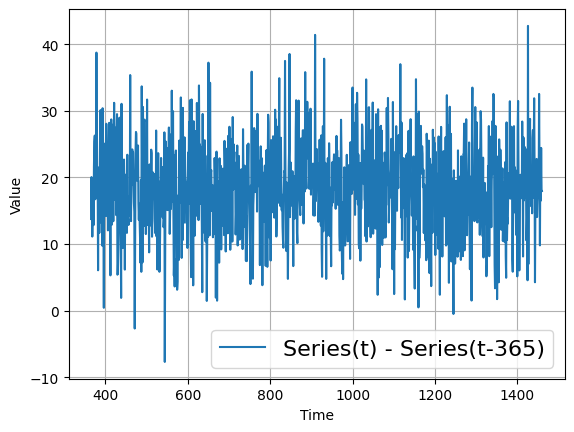

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figure=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) - Series(t-365)")
plt.show()

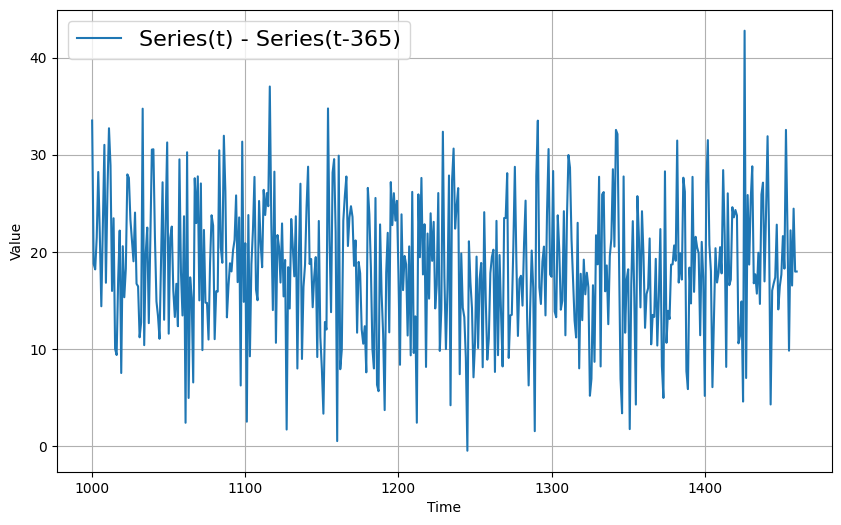

In [ ]:
#focusing on the validation period
plt.figure(figsize = (10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label='Series(t) - Series(t-365)')
plt.show()

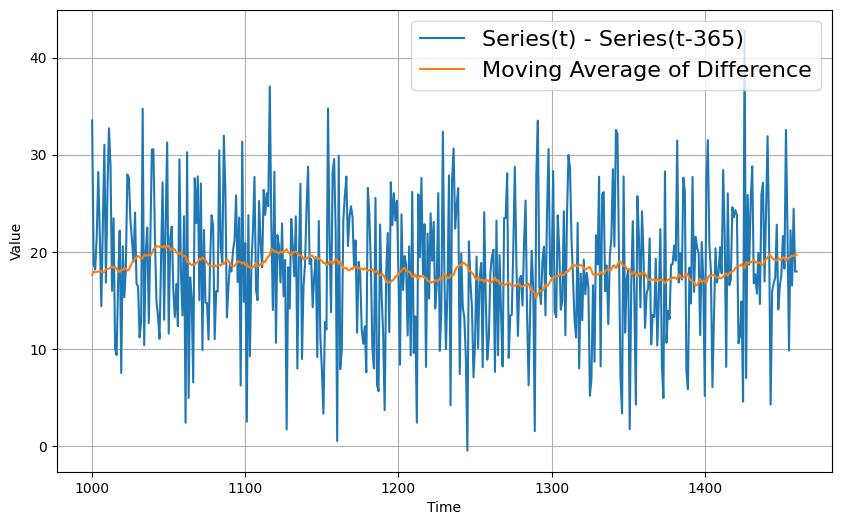

In [ ]:
#now let's use moving average now that we have removed the trend and seasonality
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label = "Series(t) - Series(t-365)")
plot_series(time_valid, diff_moving_avg, label = 'Moving Average of Difference')

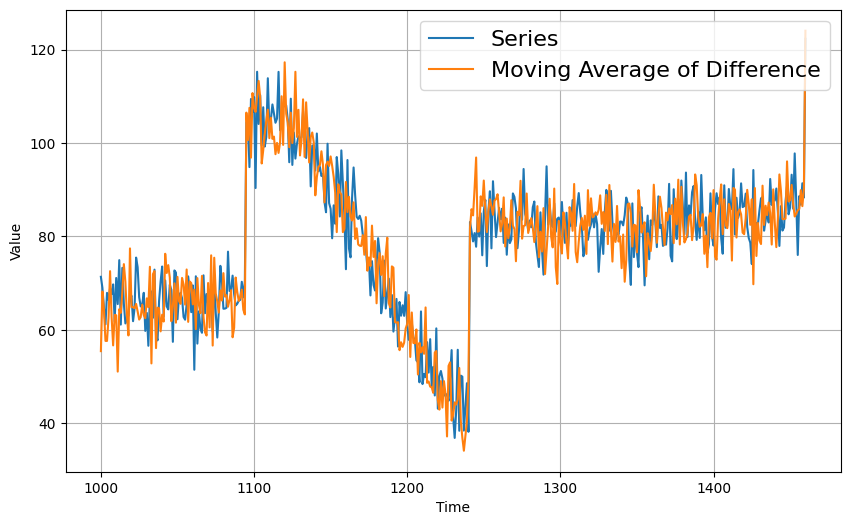

In [ ]:
#let's bring back the trend and seasonality by adding the past values from t-365
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid, label = 'Series')
plot_series(time_valid, diff_moving_avg_plus_past, label = 'Moving Average of Difference')
plt.show()

In [ ]:
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(x_valid, diff_moving_avg_plus_past)
mae = mae_metric.result().numpy()
print(mae)


5.8393106


[]

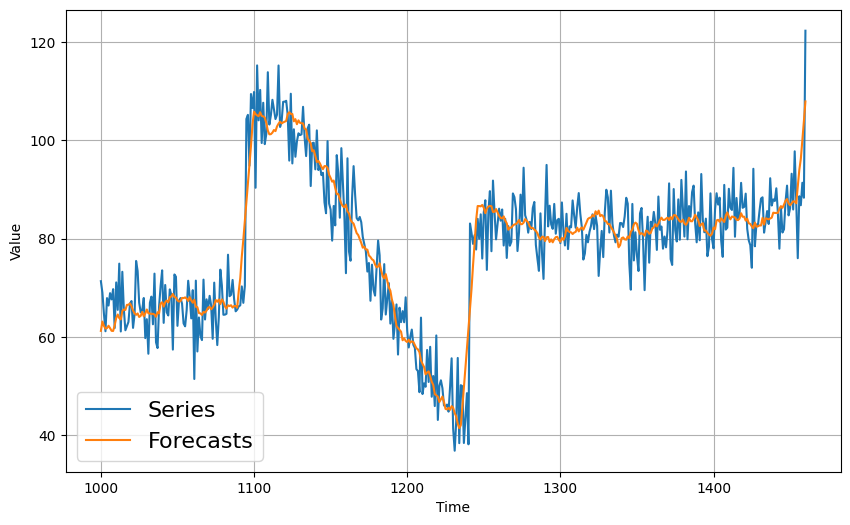

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time-370:-359], 11)+ diff_moving_avg

plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label='Forecasts')
plt.plot()


In [ ]:
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(x_valid, diff_moving_avg_plus_smooth_past)
mae = mae_metric.result().numpy()
print(mae)

4.5668597


Transforming time series into a format you can use for training your ml model

Time Windows
to train a model that will forecast the next step given the previous 20 steps

In [ ]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [ ]:
dataset = dataset.window(5, shift = 1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end = '')
    print()


01234
12345
23456
34567
45678
56789
6789
789
89
9


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end = '')
    print()


01234
12345
23456
34567
45678
56789


In [ ]:
#to get a single dataset with multiple batches of data, you use the flat_map method

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:])) #lambda will return all elements except for the last one and one with just the last element. by calling the map method, I am transforming my dataset to convert each of the windows into two temsors

for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 10) #introducing shuffle ensures your data is independent and identically distributed which is needed for gradient descent

for x, y in dataset:
    print(x.numpy(), y.numpy())

[1 2 3 4] [5]
[5 6 7 8] [9]
[4 5 6 7] [8]
[2 3 4 5] [6]
[0 1 2 3] [4]
[3 4 5 6] [7]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 10)
dataset = dataset.batch(2).prefetch(1) #prefetch will tell tensorflow to load the next batch of data while working on a batch of data
for x,y in dataset:
    print("x is:",x.numpy())
    print('y is:', y.numpy())

x is: [[2 3 4 5]
 [1 2 3 4]]
y is: [[6]
 [5]]
x is: [[0 1 2 3]
 [3 4 5 6]]
y is: [[4]
 [7]]
x is: [[5 6 7 8]
 [4 5 6 7]]
y is: [[9]
 [8]]


In [ ]:
#creating a function out of it to convert any time series into a tensorflow dataset that you can load into your tensorflow model

def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset